In [10]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

  Activating project at `~/tinympc-julia/quadrotor_traj_gen`


In [11]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using JuMP
using COSMO
using OSQP
using Printf

In [12]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo: Quadrotor

vis = Visualizer()

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat Visualizer with path /meshcat at http://127.0.0.1:8701

In [13]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2]
        v[3] 0 -v[1]
        -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s -v'
        v s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1, 3); I]
function qtoQ(q)
    return H' * T * L(q) * T * L(q) * H
end
function G(q)
    G = L(q) * H
end
function rptoq(ϕ)
    (1 / sqrt(1 + ϕ' * ϕ)) * [1; ϕ]
end
function qtorp(q)
    q[2:4] / q[1]
end
function E(q)
    E = BlockDiagonal([1.0 * I(3), G(q), 1.0 * I(6)])
end

E (generic function with 1 method)

In [14]:
# Quadrotor parameters
m = 0.041
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-6*scale # u is PWM in range [0...1]
# kt=1
km = kt*thrustToTorque #4.4733e-8

h = 1/500

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4      # number of controls
nx = Nx̃
nu = Nu

4

In [15]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = [0; 0; -g] + (1/m)*Q*[zeros(2,4); kt*ones(1,4)]*u 

  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] = xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [16]:
#Goal state
@show uhover = (m * g / kt / 4) * ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

uhover = (((m * g) / kt) / 4) * ones(4) = [0.6833333552752301, 0.6833333552752301, 0.6833333552752301, 0.6833333552752301]


In [17]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u 
end

discrete_dynamics (generic function with 1 method)

In [66]:
#Feedback tracking controller
include("tinyMPC.jl")
include("mpc_JuMP.jl")
Tfinal = 1              # final time
N = Int(Tfinal/h)+1     # number of time steps
t_vec = h*(0:N-1)

# Cost weights
# Saved
# max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.05;  0.5; 0.5; 0.5;  0.5; 0.5; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/10
max_dev_x = [0.1; 0.1; 0.1; 0.2; 0.2; 0.03; 0.5; 0.5; 0.5; 0.7; 0.7; 0.2] / 10
max_dev_u = [0.5; 0.5; 0.5; 0.5]
Q = diagm(1 ./ (max_dev_x .^ 2))
R = diagm(1 ./ (max_dev_u .^ 2))
Qf = 100 * Q

# Penalty
ρ = 5
R̃ = R + ρ*I;

# Precompute
cache = (
    Ã = Ã,
    B̃ = B̃,
    Kinf = zeros(nu,nx),
    Pinf = zeros(nx,nx),
    Quu_inv = zeros(nu,nu),
    AmBKt = zeros(nx,nx), 
    coeff_d2p = zeros(nx,nu), 
)


# Create trajectory to follow
Xref = [[zeros(3); 1; zeros(9)] for i = 1:N]
Δx̃ref = [zeros(nx) for i = 1:N]
ΔUref = [zeros(nu) for i = 1:N-1]

# Hovering
# Xref = [xg for i = 1:N]

# Number-eight
# Xref[1:N-1] = [[1.2*cos(t)*sin(t);1.2*cos(t);0.6;1;zeros(9)] for t = range(-pi/2, 3*pi/2+ 2*2*pi, length = N - 1)]  
# Xref[end] .= Xref[end-1]

# scale = 1
# loops = 1
# Xref[1:N-1] = [[scale*sin(2*t)/2; scale*cos(t); 1; 1; zeros(9)] for t = range(-pi/2*loops, 3*pi/2*loops, length = N-1)];
# Xref[end] .= Xref[end-1]

# Fast circle
# radius = 1.0
# Xref = [[radius*cos(t); radius*sin(t); 0.6; 1; zeros(9)] for t = range(-pi/2, 3*pi/2+4*pi, length = N)]  

# Good Perching
# p0 = [0; 0; 1.7; qtorp(L(qg)' * [1; 0; 0; 0])]
# p1 = [2; 0; 1.7; qtorp(L(qg)' * [0.7071068; 0; -0.7071068; 0])]
# range1 = collect(LinRange(p0, p1, N - 1 ))
# r = append!(r, [p1])
# p0 = [1.5; 0; 1.7; qtorp(L(qg)' * [0.7071068; 0; -0.7071068; 0])]
# p1 = [1; 0; 1.7; qtorp(L(qg)' * [1; 0; 0; 0])]
# p2 = [1; 0; 1.7; qtorp(L(qg)' * [1; 0; 0; 0])]
# t_into_wall = 0.3
# N_into_wall = Int(t_into_wall/h)
# range1 = collect(LinRange(p0, p1, N - 1 -N_into_wall))
# range2 = collect(LinRange(p1, p2, N_into_wall))
# r = append!(range1, range2)
# r = append!(r, [p2])

hover = [1; 0; 1.25; qtorp(L(qg)' * [1; 0; 0; 0])]
for k = 1:N
    Δx̃ref[k][1:6] .= hover
end

# p0 = [0; 0; 1.7; qtorp(L(qg)' * [1; 0; 0; 0])]
# p1 = [1.6; 0; 1.7; qtorp(L(qg)' * [1; 0; 0; 0])]
# p2 = [2; 0; 1.7; qtorp(L(qg)' * [0.7071068; 0; -0.7071068; 0])]
# t_into_wall = 0.4
# N_into_wall = Int(t_into_wall/h)
# range1 = collect(LinRange(p0, p1, N - 1 -N_into_wall))
# range2 = collect(LinRange(p1, p2, N_into_wall))
# r = append!(range1, range2)
# r = append!(r, [p2])
# for k = 1:N
#     Δx̃ref[k][1:6] .= r[k]
#     if k <= N
#         # Δx̃ref[k][7:9] = (Δx̃ref[k+1][1:3] - Δx̃ref[k][1:3]) / h
#         Δx̃ref[k][7] = 3.0
#         # Δx̃ref[k][10:12] = (Δx̃ref[k+1][4:6] - Δx̃ref[k][4:6]) / h
#     end
# end

# Triangle
# p0 = [0; 0; 1.0]; p1 = [3; 4; 1.]; p2 = [0; 8; 1.]; p3 = [0; 0; 1.0]
# range1 = collect(LinRange(p0, p1, round(Int,(N)/3)))
# range2 = collect(LinRange(p1, p2, round(Int,(N)/3)))
# range3 = collect(LinRange(p2, p3, round(Int,(N)/3)+1))
# range123 = [range1; range2; range3]
# for k = 1:N
#     Xref[k][1:3] .= range123[k]
# end

## Square
# p0 = [0; 0; 1]; p1 = [2; 0; 1]; p2 = [2; 2; 1]; p3 = [0; 2; 1]
# range1 = collect(LinRange(p0, p1, round(Int,(N)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(N)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(N)/4)))
# range4 = collect(LinRange(p3, p0, round(Int,(N)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:N
#     Xref[k][1:3] .= range1234[k]
# end

## Vertical Circular Flip 
# p0 = [0; 0; 1; 1; 0; 0; 0]; 
# p1 = [0; 0.5; 1.5; 0.7071068; 0.7071068; 0; 0]; p2 = [0; 0; 2; 0; 1; 0; 0]; 
# p3 = [0; -0.5; 1.5; -0.7071068; 0.7071068; 0; 0]; p4 = [0; 0; 1; 1; 0; 0; 0];
# range1 = collect(LinRange(p0, p1, round(Int,(N)/4)))
# range2 = collect(LinRange(p1, p2, round(Int,(N)/4)))
# range3 = collect(LinRange(p2, p3, round(Int,(N)/4)))
# range4 = collect(LinRange(p3, p4, round(Int,(N)/4)+1))
# range1234 = [range1; range2; range3; range4]
# for k = 1:N
#     Xref[k][1:7] .= range1234[k]
#     Xref[k][4:7] .= Xref[k][4:7]/norm(Xref[k][4:7])
# end
# p0 = [0; 0; 1; 1; 0; 0; 0]; p1 = [0; 0.5; 1; 1; 0; 0; 0];
# p2 = [0.5; 1; 1; -0.6669381; 0; -0.7451132; 0]; p3 = [0; 2; 1; 1; 0; 0; 0]; 
# range1 = collect(LinRange(p0, p1, round(Int,(N)/3)))
# range2 = collect(LinRange(p1, p2, round(Int,(N)/3)))
# range3 = collect(LinRange(p2, p3, round(Int,(N)/3)+1))
# range1234 = [range1; range2; range3]
# for k = 1:N 
#     Xref[k][1:7] .= range1234[k]
#     Xref[k][4:7] .= Xref[k][4:7]/norm(Xref[k][4:7])
# end

# Velocity reference: speeds up the tracking but less smooth
# for i = 1:N-1
#     Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/h
# end
# for k = 1:N
#     x = Xref[k]
#     q = x[4:7]
#     ϕ = qtorp(L(qg)'*q)   
#     Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
# end  

optimizer = JuMP.optimizer_with_attributes(OSQP.Optimizer,
    "verbose" => true,
    "eps_abs" => 1e-3,
    "eps_rel" => 1e-3,
    "eps_prim_inf" => 1e-3,
    "eps_dual_inf" => 1e-3,
    "max_iter" => 1000)
# "rho"=>1e-2,
# "scaling"=>0,
# "alpha"=>1.0,)  

model = Model(optimizer)

u_min = 0.1 * [1; 1; 1; 1] - uhover
u_max = uhover - 0.1 * [1; 1; 1; 1]

# state is x y v θ
x_min = -100 * ones(nx)
x_min[3] = -0.2
x_max = 100 * ones(nx)
x_max[3] = 0.2

# previous MPC iterate
X = [zeros(nx) for i = 1:N]
X[1][1:6] .= Δx̃ref[1][1:6]
U = [1 * uhover for k = 1:N-1]

params = (
    nx=nx, nu=nu, ncx=0, ncu=1, ncg=1, ncu_cone=0,
    N=N, Q=Q, R=R, Qf=Qf,
    u_min=u_min, u_max=u_max,
    x_min=x_min, x_max=x_max,
    Xref=Δx̃ref, Uref=ΔUref, dt=h
);

Δx̃ref

501-element Vector{Vector{Float64}}:
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 ⋮
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 0.0, 1.7, 0.0, 0.0, 0.0

In [59]:
u = mpc_JuMP!(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=false)

  0.066642 seconds (244.02 k allocations: 32.210 MiB)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 8012, constraints m = 10024
          nnz(P) + nnz(A) = 55036
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-03, eps_dual_inf = 1.0e-03,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 1000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.7438e+06   3.00e+00   6.00e+09   1.00e-01   1.32e-02s
  75  -1.2670e+07   5.97e-04   3.08e+02   1.00e-0

4-element Vector{Float64}:
 -0.49114547460168234
  0.5458641871355723
  0.3681993654420548
 -0.3847003802275979

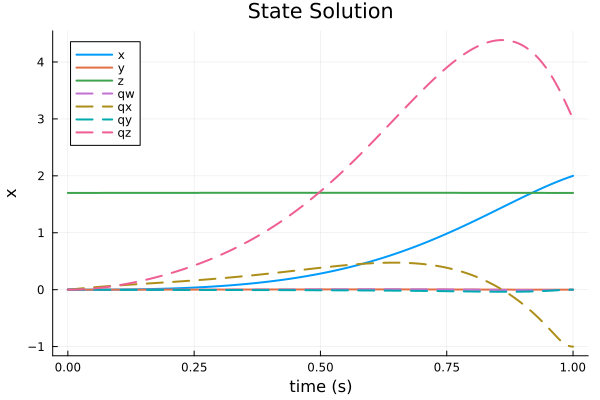

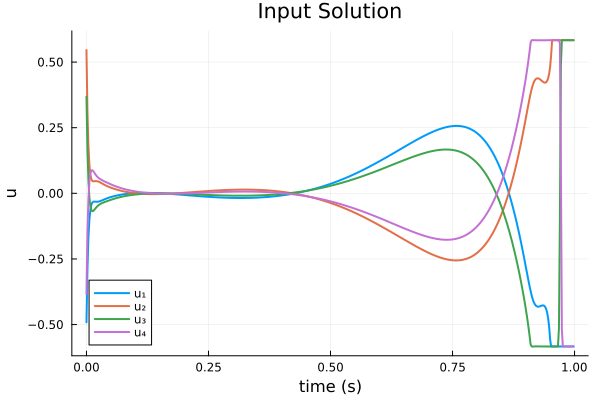

In [60]:
# Plots
Xsim_m = mat_from_vec(X)
Usim_m = mat_from_vec(U)
display(plot(t_vec, Xsim_m[1:7, :]', label=["x" "y" "z" "qw" "qx" "qy" "qz"],
  linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
  title="State Solution", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1], Usim_m', label=["u₁" "u₂" "u₃" "u₄"],
  title="Input Solution", linewidth=[2 2 2 2 2 2 2],
  xlabel="time (s)", ylabel="u"))

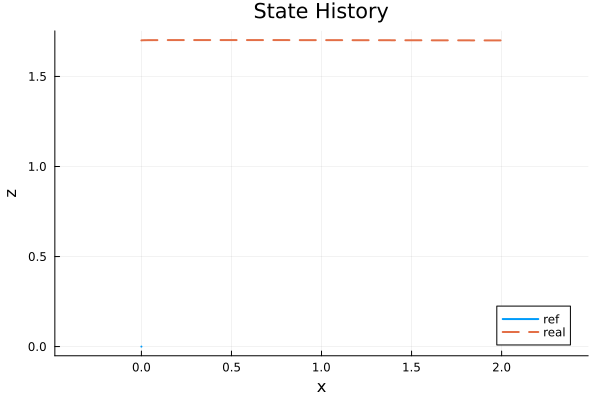

In [61]:
Xsim_m = mat_from_vec(Xref[1:N])
plot(Xsim_m[1, :], Xsim_m[3, :], label="ref",
  linestyle=:solid, linewidth=2,
  title="State History", xlabel="x", ylabel="z")
Xsim_m = mat_from_vec(X[1:N])
display(plot!(Xsim_m[1, :], Xsim_m[3, :], label="real", linestyle=:dash, linewidth=2,
  title="State History", xlabel="x", ylabel="z", aspect_ratio=:equal))

In [62]:
# Visualize in MeshCat
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)
X1 = [zeros(13) for i = 1:N]
for k = 1:N
  x = 1 * X[k]
  ϕ = 1 * x[4:6]
  qq = 1 * rptoq(ϕ)
  X1[k] .= [x[1:3] + rg; qq; x[7:9] + vg; x[10:12] + ωg]
end
X2 = [SVector{13}(x) for x in X1];
visualize!(vis, model, t_vec[end], X2)

In [63]:
X

501-element Vector{Vector{Float64}}:
 [4.869019211761558e-9, -2.8590311441478905e-9, 1.7000000099489334, 4.475146570660746e-9, -5.013994368914357e-9, -2.774157041722789e-8, 7.646861130549485e-9, -5.837247146781961e-9, 1.9635959742789037e-8, -3.957413429909207e-9, -1.4074447535928366e-8, -4.5225670693887694e-8]
 [1.316430208705571e-8, -5.433501332038384e-9, 1.7000002942656671, -4.53135192522975e-5, 0.0005215766641573073, -2.9843199399787408e-5, 6.837403572373795e-6, 5.809952231093523e-7, 0.00027436766233483224, -0.0906447634912693, 1.043173597898049, -0.0595754404305471]
 [6.757776285212807e-8, -4.064847656220546e-9, 1.700001119911335, -0.00015154218121106623, 0.0018335938230992185, -0.00010444681099664329, 5.129522982545027e-5, 4.335661454346483e-6, 0.0005413484324286514, -0.12182115713476394, 1.5808711836855365, -0.08957634337756115]
 [2.68470222703284e-7, 9.298292701528207e-9, 1.700002472268112, -0.0002750243571235257, 0.003537548084213055, -0.00020046250401669328, 0.0001558796418449

In [67]:
# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data, flag)
  declare = var_type * " " * var_name * @sprintf("[%d][%d]", length(data), length(data[1]))
  def = declare * " = {\n"
  for i = 1:length(data)
    def = def * "{"
    for j = 1:length(data[1])
      def = def * @sprintf("%.4f", data[i][j])
      if j < length(data[1])
        def = def * ","
      end
    end
    def = def * "}"
    if i < length(data)
      def = def * ",\n"
    end
  end
  def = def * "}"

  open(filename * ".h", flag) do io
    println(io, def * ";\n")
  end
  return true
end
###################
X_ref_data = [X[i][1:nx] for i = 1:N]
#interpl_step = Int(100 / h)
# X_ref_data1 = [zeros(nx) for i = 1:N*interpl_step-(interpl_step-1)]
# for k = 1:N-1
#   X_ref_data1[((k-1)*interpl_step+1):k*interpl_step] .= collect(LinRange(X_ref_data[k], X_ref_data[k+1], interpl_step + 1))[1:interpl_step]
# end
# # X_ref_data1[((N-1)*interpl_step+1):N*interpl_step] .= fill(X_ref_data1[(N-1)*interpl_step], interpl_step)
# X_ref_data1[N*interpl_step-(interpl_step-1)] .= X_ref_data[N]

export_vec_to_c("data", "static const float", "X_ref_data", X_ref_data, "w")
export_vec_to_c("hover", "static const float", "X_ref_data", Δx̃ref, "w")


true

In [65]:
U_ref_data = [U[i][1:nu] for i = 1:N-1]
U_ref_data1 = [zeros(nu) for i = 1:N*interpl_step-(interpl_step-1)-1]
for k = 1:N-2
  U_ref_data1[(k-1)*interpl_step+1:k*interpl_step] .= collect(LinRange(U_ref_data[k], U_ref_data[k+1], interpl_step + 1))[1:interpl_step]
end
U_ref_data1[(N-2)*interpl_step+1] .= U_ref_data[N-1]
export_vec_to_c("data", "static const float", "U_ref_data", U_ref_data1, "a")

LoadError: UndefVarError: `interpl_step` not defined